### Mean reversion strategy using the absolute price oscillator trading signal

1. We will fetch data the same way we have done in the past. Let's fetch 4 years of `GOOG` data. This code will use the `DataReader` function from the `pandas_datareader` package. This function will fetch the `GOOG` prices from Yahoo Finance between `2014-01-2014` and `2018-01-01`. If the `.pkl` file used to store the data on the disk is not present, the `GOOG_data.pkl` file will be created. By doing that, we ensure that we will use the file to fetch the `GOOG` data for future use:

In [1]:
import pandas as pd
from pandas_datareader import data

In [2]:
import yfinance as yf
yf.pdr_override()

In [3]:
# Fetch daily data for 4 years
SYMBOL='GOOG'
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME=SYMBOL + '_data.pkl'

In [4]:
try:
    df = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
    # df = data.DataReader(SYMBOL, 'yahoo', start_date, end_date)
    df = data.get_data_yahoo(SYMBOL, start=start_date, end=end_date)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,555.647278,556.788025,552.060730,554.481689,554.481689,3656400
2014-01-03,555.418152,556.379578,550.401978,550.436829,550.436829,3345800
2014-01-06,554.426880,557.340942,551.154114,556.573853,556.573853,3551800
2014-01-07,560.399475,567.717041,558.486633,567.303589,567.303589,5124300
2014-01-08,570.860291,571.517822,564.528992,568.484192,568.484192,4501700
...,...,...,...,...,...,...
2017-12-26,1058.069946,1060.119995,1050.199951,1056.739990,1056.739990,760600
2017-12-27,1057.390015,1058.369995,1048.050049,1049.369995,1049.369995,1271900
2017-12-28,1051.599976,1054.750000,1044.770020,1048.140015,1048.140015,837100


2. Now we will define some constants and variables we will need to perform Fast and Slow EMA calculations and APO trading signal:

In [5]:
# Variables/constants for EMA Calculation:
NUM_PERIODS_FAST = 10 # Static time period parameter for the fast EMA
K_FAST = 2 / (NUM_PERIODS_FAST + 1) # Static smoothing factor parameter for fast EMA
ema_fast = 0
ema_fast_values = [] # we will hold fast EMA values for visualization purposes

NUM_PERIODS_SLOW = 40 # Static time period parameter for slow EMA
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) # Static smoothing factor parameter for slow EMA
ema_slow = 0
ema_slow_values = [] # we will hold slow EMA values for visualization purposes

apo_values = [] # track computed absolute price oscillator value signals

3. We will also need variables that define/control strategy trading behavior and position and PnL management:

In [6]:
# Variables for Trading Strategy trade, position & pnl management:
orders = [] # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = [] # Container for tracking positions,
                # +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = [] # Container for tracking total_pnls, this is the sum of closed_pnl
            # i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buy_price = 0 # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0 # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0 # Current position of the trading strategy
buy_sum_price_qty = 0 # Summation of products of buy_trade_price and buy_trade_qty for every buy
                        # Trade made since last time being flat
buy_sum_qty = 0 # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0 # Summation of products of sell_trade_price and sell_trade_qty for every sell
                        # Trade made since last time being flat
sell_sum_qty = 0 # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0 # Open/Unrealized PnL marked to market
closed_pnl = 0 # Closed/Realized PnL so far

4. Finally, we clearly define the entry thresholds, the minimum price change since last trade, the minimum profit to expect per trade, and the number of shares to trade per trade:

In [7]:
# Constants that define strategy behavior/thresholds
APO_VALUE_FOR_BUY_ENTRY = -10 # APO trading signal value below which to enter buy-orders/long-position
APO_VALUE_FOR_SELL_ENTRY = 10 # APO trading signal value above which to enter sell-orders/short-position
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10 # Minimum price change since last trade before considering trading again,
                                        # this is to prevent over-trading at/around same prices
NUM_SHARES_PER_TRADE = 10 # Number of shares to buy/sell on every trade
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE # Minimum Open/Unrealized profit at which to close positions
                                                # and lock profits

5. Now, let's look at the main section of the trading strategy, which has logic for the following:
* Computation/updates to Fast and Slow EMA and the APO trading signal
* Reacting to trading signals to enter long or short positions
* Reacting to trading signals, open positions, open PnLs, and market prices to close long or short positions:

In [8]:
close=df['Close']
for close_price in close:
    # This section updates fast and slow EMA and computes APO trading signal
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_FAST + ema_fast
        ema_slow = (close_price - ema_slow) * K_SLOW + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    apo = ema_fast - ema_slow
    apo_values.append(apo)
    
    # This section checks trading signal against trading parameters/thresholds and positions, to trade.

    # We will perform a sell trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is above Sell-Entry threshold and the difference between last trade-price and
    #    current-price is different enough.
    # 2. We are long( +ve position ) and either APO trading signal value is at or above 0 or current position is
    #    profitable enough to lock profit.
    if ((apo > APO_VALUE_FOR_SELL_ENTRY and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE)
        or # APO above sell entry threshold, we should sell
        (position > 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))): # long from -ve APO and APO has gone
                                                                            # positive or position is profitable,
                                                                            # sell to close position
        orders.append(-1) # mark the sell trade
        last_sell_price = close_price
        position -= NUM_SHARES_PER_TRADE # reduce position by the size of this trade
        sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update vwap sell-price
        sell_sum_qty += NUM_SHARES_PER_TRADE
        print( "Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )

    # We will perform a buy trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is below Buy-Entry threshold and the difference between last trade-price and
    #    current-price is different enough.
    # 2. We are short( -ve position ) and either APO trading signal value is at or below 0 or current position is
    #    profitable enough to lock profit.
    elif ((apo < APO_VALUE_FOR_BUY_ENTRY and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE)
        or # APO below buy entry threshold, we should buy
          (position < 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))): # short from +ve APO and APO has gone
                                                                            # negative or position is profitable,
                                                                            # buy to close position
        orders.append(+1) # mark the buy trade
        last_buy_price = close_price
        position += NUM_SHARES_PER_TRADE # increase position by the size of this trade
        buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update the vwap buy-price
        buy_sum_qty += NUM_SHARES_PER_TRADE
        print( "Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )
    else:
        # No trade since none of the conditions were met to buy or sell
        orders.append(0)

    positions.append(position)

    # This section updates Open/Unrealized & Closed/Realized positions
    open_pnl = 0
    if position > 0:
        if sell_sum_qty > 0: # long position and some sell trades have been made against it,
                                # close that amount based on how much was sold against this long position
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    elif position < 0:
        if buy_sum_qty > 0: # short position and some buy trades have been made against it,
                                # close that amount based on how much was bought against this short position
            open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
    else:
        # flat, so update closed_pnl and reset tracking variables for positions & pnls
        closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
    pnls.append(closed_pnl + open_pnl)

OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Sell  10  @  580.334778 Position:  -10
OpenPnL:  0.0  ClosedPnL:  0  TotalPnL:  0.0
OpenPnL:  24.50806000000057  ClosedPnL:  0  TotalPnL:  24.50806000000057
OpenPnL:  205.18128000000047  ClosedPnL:  0  TotalPnL:  205.18128000000047
Buy  10  @  548.558838 Position:  0
OpenPnL:  0  ClosedPnL:  317.7593999999999  TotalPnL:  317.7593999999999
OpenPnL:  0  ClosedPnL:  317.7593999999999  TotalPnL:  317.7593999999999
OpenPnL:  0  ClosedPnL:  317.7593999999999  TotalPnL:

9. Now we look at some Python/Matplotlib code to see how to gather the relevant results of the trading strategy such as market prices, Fast and Slow EMA values, APO values, Buy and Sell trades, Positions and PnLs achieved by the strategy over its lifetime and then plot them in a manner that gives us insight into the strategy's behavior:

In [9]:
# This section prepares the dataframe from the trading strategy results and visualizes the results
df = df.assign(ClosePrice=pd.Series(close, index=df.index))
df = df.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=df.index))
df = df.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=df.index))
df = df.assign(APO=pd.Series(apo_values, index=df.index))
df = df.assign(Trades=pd.Series(orders, index=df.index))
df = df.assign(Position=pd.Series(positions, index=df.index))
df = df.assign(Pnl=pd.Series(pnls, index=df.index))

10. Now we will add columns to the data frame with different series that we computed in the previous sections, first the Market Price and then the fast and slow EMA values. We will also have another plot for the APO trading signal value. In both plots, we will overlay buy and sell trades so we can understand when the strategy enters and exits positions:

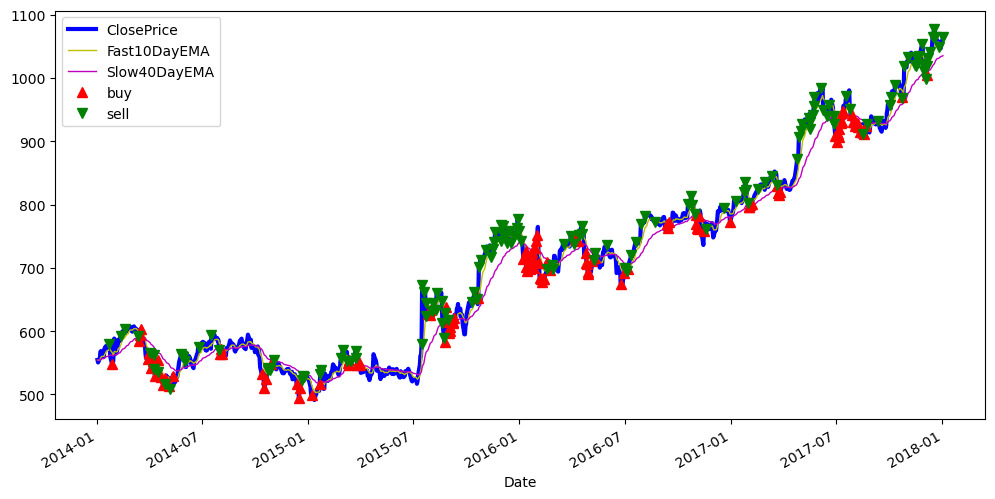

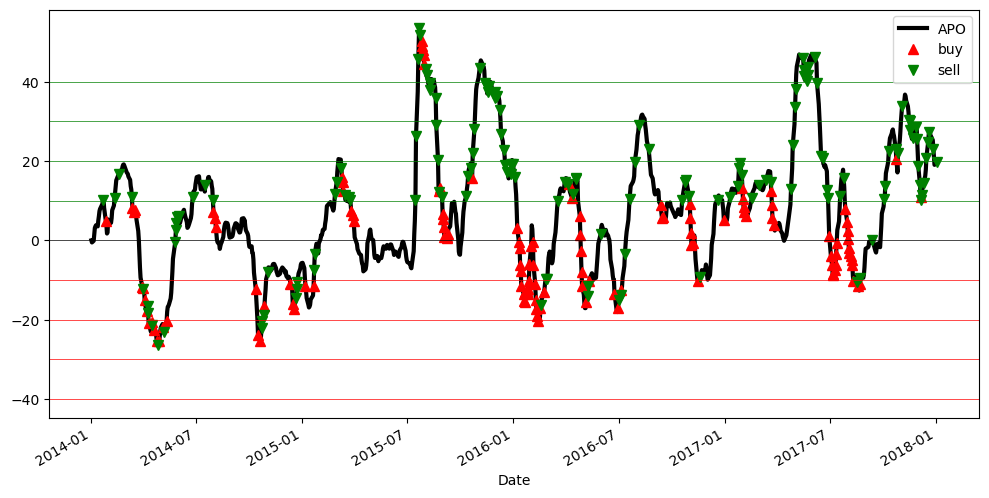

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df['ClosePrice'].plot(color='blue', lw=3., legend=True)
df['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
df['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(df.loc[ df.Trades == 1 ].index, df.ClosePrice[df.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(df.loc[ df.Trades == -1 ].index, df.ClosePrice[df.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
df['APO'].plot(color='k', lw=3., legend=True)
plt.plot(df.loc[ df.Trades == 1 ].index, df.APO[df.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(df.loc[ df.Trades == -1 ].index, df.APO[df.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

11. As we will see in the following code, those trades are the ones executed to close profits. Let's observe the position and PnL evolution over the lifetime of this strategy:

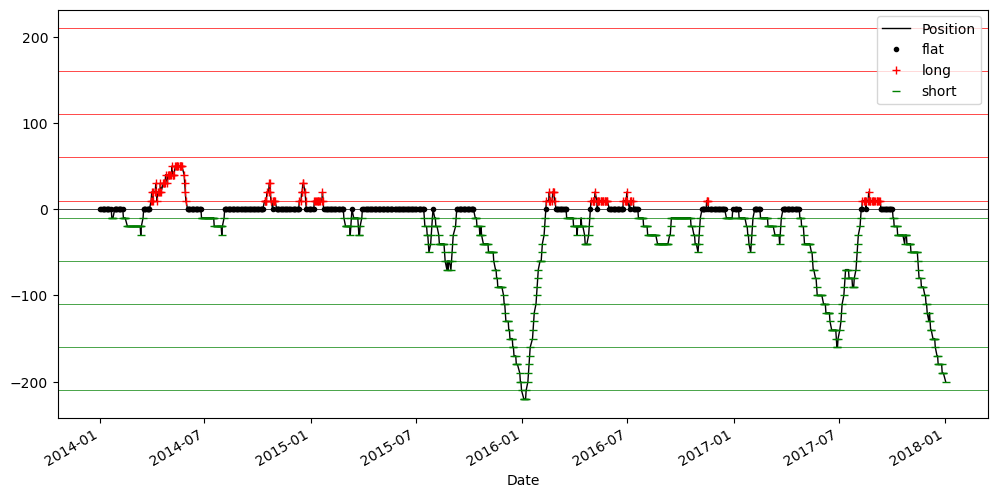

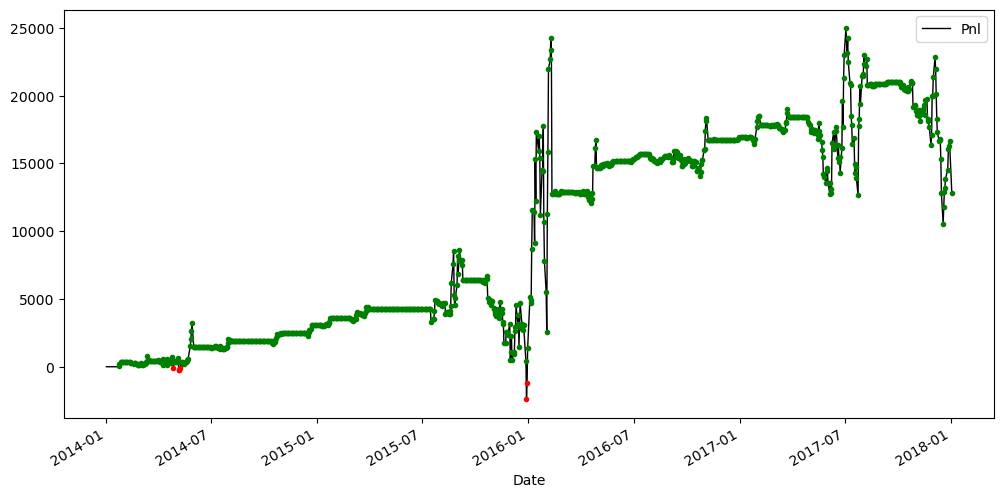

In [11]:
plt.figure(figsize=(12, 6))
df['Position'].plot(color='k', lw=1., legend=True)
plt.plot(df.loc[ df.Position == 0 ].index, df.Position[ df.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(df.loc[ df.Position > 0 ].index, df.Position[ df.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(df.loc[ df.Position < 0 ].index, df.Position[ df.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5 ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( -NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5 ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
df['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(df.loc[ df.Pnl > 0 ].index, df.Pnl[ df.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(df.loc[ df.Pnl < 0 ].index, df.Pnl[ df.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()

df['BasicMeanReversionPnl'] = df['Pnl']
# df.to_csv("basic_mean_reversion.csv", sep=",")

### Mean reversion strategy that dynamically adjusts for changing volatility

* Instead of having static `K_FAST` and `K_SLOW` smoothing factors for the fast and slow EMA, we will instead make them additionally a function of volatility and use `K_FAST * stdev_factor` and `K_SLOW * stdev_factor`, to make them more reactive to newest observations during periods of higher than normal volatility, which makes intuitive sense.
* Instead of using static `APO_VALUE_FOR_BUY_ENTRY` and `APO_VALUE_FOR_SELL_ENTRY` thresholds for entering positions based on the primary trading signal APO, we will also incorporate volatility to have dynamic thresholds `APO_VALUE_FOR_BUY_ENTRY * stdev_factor` and `APO_VALUE_FOR_SELL_ENTRY * stdev_factor`. This makes us less aggressive in entering positions during periods of higher volatility, by increasing the threshold for entry by a factor of volatility, which also makes intuitive sense based on what we discussed in the previous section.
* Finally, we will incorporate volatility in one last threshold and that is by having a dynamic expected profit threshold to lock in profit in a position. In this case, instead of using the static `MIN_PROFIT_TO_CLOSE` threshold, we will use a dynamic `MIN_PROFIT_TO_CLOSE / stdev_factor`. Here, the idea is to be more aggressive in exciting positions during periods of increased volatility, because as we discussed before, during periods of higher than normal volatility, it is riskier to hold on to positions for longer periods of time.

In [12]:
# Variables/constants for EMA Calculation:
NUM_PERIODS_FAST = 10 # Static time period parameter for the fast EMA
K_FAST = 2 / (NUM_PERIODS_FAST + 1) # Static smoothing factor parameter for fast EMA
ema_fast = 0
ema_fast_values = [] # we will hold fast EMA values for visualization purposes

NUM_PERIODS_SLOW = 40 # Static time period parameter for slow EMA
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) # Static smoothing factor parameter for slow EMA
ema_slow = 0
ema_slow_values = [] # we will hold slow EMA values for visualization purposes

apo_values = [] # track computed absolute price oscillator value signals

# Variables for Trading Strategy trade, position & pnl management:
orders = [] # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = [] # Container for tracking positions, +ve for long positions, -ve for short positions,
                #  0 for flat/no position
pnls = [] # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl
            # i.e. pnls for open-position marked to market price

last_buy_price = 0 # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0 # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0 # Current position of the trading strategy
buy_sum_price_qty = 0 # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade
                        # made since last time being flat
buy_sum_qty = 0 # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0 # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade
                        # made since last time being flat
sell_sum_qty = 0 # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0 # Open/Unrealized PnL marked to market
closed_pnl = 0 # Closed/Realized PnL so far

# Constants that define strategy behavior/thresholds
APO_VALUE_FOR_BUY_ENTRY = -10 # APO trading signal value below which to enter buy-orders/long-position
APO_VALUE_FOR_SELL_ENTRY = 10 # APO trading signal value above which to enter sell-orders/short-position
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10 # Minimum price change since last trade before considering trading again,
                                    # this is to prevent over-trading at/around same prices
NUM_SHARES_PER_TRADE = 10 # Number of shares to buy/sell on every trade
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE # Minimum Open/Unrealized profit at which to close positions
                                                # and lock profits

In [13]:
import statistics as stats
import math as math

In [14]:
# Constants/variables that are used to compute standard deviation as a volatility measure
SMA_NUM_PERIODS = 20 # look back period
price_history = [] # history of prices

In [15]:
close=df['Close']
for close_price in close:
    price_history.append(close_price)
    if len(price_history) > SMA_NUM_PERIODS: # we track at most 'time_period' number of prices
        del (price_history[0])

    sma = stats.mean(price_history)
    variance = 0 # variance is square of standard deviation
    for hist_price in price_history:
        variance = variance + ((hist_price - sma) ** 2)

    stdev = math.sqrt(variance / len(price_history))
    stdev_factor = stdev/15
    if stdev_factor == 0:
        stdev_factor = 1

    # This section updates fast and slow EMA and computes APO trading signal
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_FAST*stdev_factor + ema_fast
        ema_slow = (close_price - ema_slow) * K_SLOW*stdev_factor + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    apo = ema_fast - ema_slow
    apo_values.append(apo)

    # This section checks trading signal against trading parameters/thresholds and positions, to trade.

    # We will perform a sell trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is above Sell-Entry threshold and the difference between last trade-price
    #    and current-price is different enough.
    # 2. We are long( +ve position ) and either APO trading signal value is at or above 0 or current position
    #    is profitable enough to lock profit.
    if ((apo > APO_VALUE_FOR_SELL_ENTRY*stdev_factor and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor)
        or # APO above sell entry threshold, we should sell
        (position > 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))): # long from -ve APO and APO
                                                                                        # has gone positive or position
                                                                                        # is profitable, sell to close
                                                                                        # position
        orders.append(-1) # mark the sell trade
        last_sell_price = close_price
        position -= NUM_SHARES_PER_TRADE # reduce position by the size of this trade
        sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update vwap sell-price
        sell_sum_qty += NUM_SHARES_PER_TRADE
        print( "Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )

    # We will perform a buy trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is below Buy-Entry threshold and the difference between last trade-price
    #    and current-price is different enough.
    # 2. We are short( -ve position ) and either APO trading signal value is at or below 0 or current position
    #    is profitable enough to lock profit.
    elif ((apo < APO_VALUE_FOR_BUY_ENTRY*stdev_factor and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor)
        or # APO below buy entry threshold, we should buy
        (position < 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))): # short from +ve APO and APO
                                                                                        # has gone negative or position
                                                                                        # is profitable, buy to close
                                                                                        # position
        orders.append(+1) # mark the buy trade
        last_buy_price = close_price
        position += NUM_SHARES_PER_TRADE # increase position by the size of this trade
        buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update the vwap buy-price
        buy_sum_qty += NUM_SHARES_PER_TRADE
        print( "Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )
    else:
        # No trade since none of the conditions were met to buy or sell
        orders.append(0)

    positions.append(position)

    # This section updates Open/Unrealized & Closed/Realized positions
    open_pnl = 0
    if position > 0:
        # long position and some sell trades have been made against it,
        # close that amount based on how much was sold against this long position
        if sell_sum_qty > 0:
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    elif position < 0:
        # short position and some buy trades have been made against it,
        # close that amount based on how much was bought against this short position
        if buy_sum_qty > 0:
            open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
    else:
        # flat, so update closed_pnl and reset tracking variables for positions & pnls
        closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
    pnls.append(closed_pnl + open_pnl)

OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Sell  10  @  573.116821 Position:  -10
OpenPnL:  0.0  ClosedPnL:  0  TotalPnL:  0.0
Sell  10  @  579.677246 Position:  -20
OpenPnL:  -65.60424999999896  ClosedPnL:  0  TotalPnL:  -65.60424999999896
OpenPnL:  -78.75489000000016  ClosedPnL:  0  TotalPnL:  -78.75489000000016
OpenPnL:  -29.738769999999022  ClosedPnL:  0  TotalPnL:  -29.738769999999022
Sell  10  @  559.81665 Position:  -30
OpenPnL:  331.60766999999964  ClosedPnL:  0  TotalPnL:  331.60766999999964
Buy  10  @  548.558838 Position:  -20
OpenPnL:  892.4560399999973  ClosedPnL:  0  Tota

In [16]:
# This section prepares the dataframe from the trading strategy results and visualizes the results
df = df.assign(ClosePrice=pd.Series(close, index=df.index))
df = df.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=df.index))
df = df.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=df.index))
df = df.assign(APO=pd.Series(apo_values, index=df.index))
df = df.assign(Trades=pd.Series(orders, index=df.index))
df = df.assign(Position=pd.Series(positions, index=df.index))
df = df.assign(Pnl=pd.Series(pnls, index=df.index))

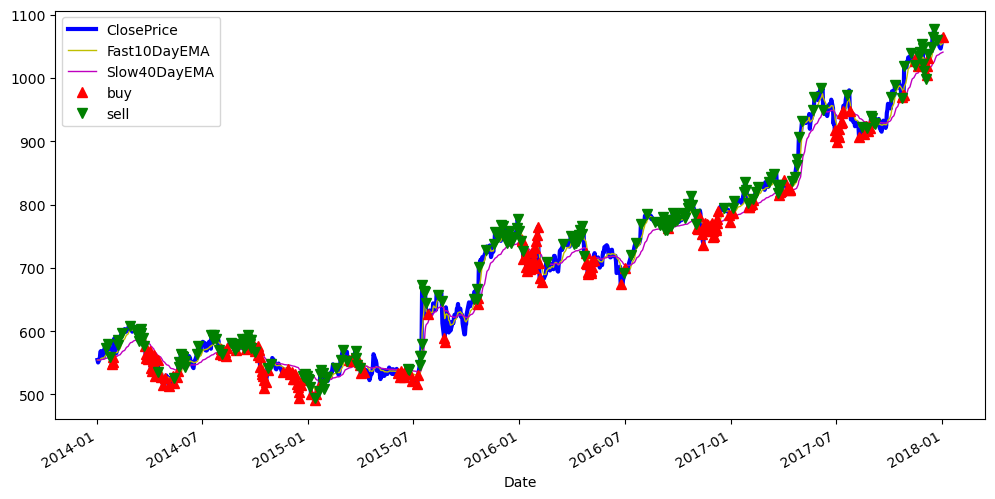

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df['ClosePrice'].plot(color='blue', lw=3., legend=True)
df['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
df['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(df.loc[ df.Trades == 1 ].index, df.ClosePrice[df.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(df.loc[ df.Trades == -1 ].index, df.ClosePrice[df.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

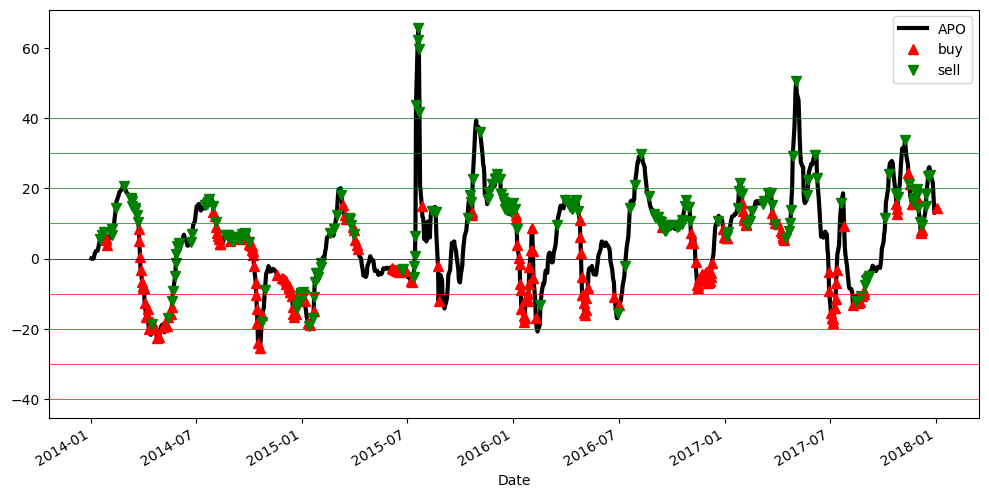

In [18]:
plt.figure(figsize=(12, 6))
df['APO'].plot(color='k', lw=3., legend=True)
plt.plot(df.loc[ df.Trades == 1 ].index, df.APO[df.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(df.loc[ df.Trades == -1 ].index, df.APO[df.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

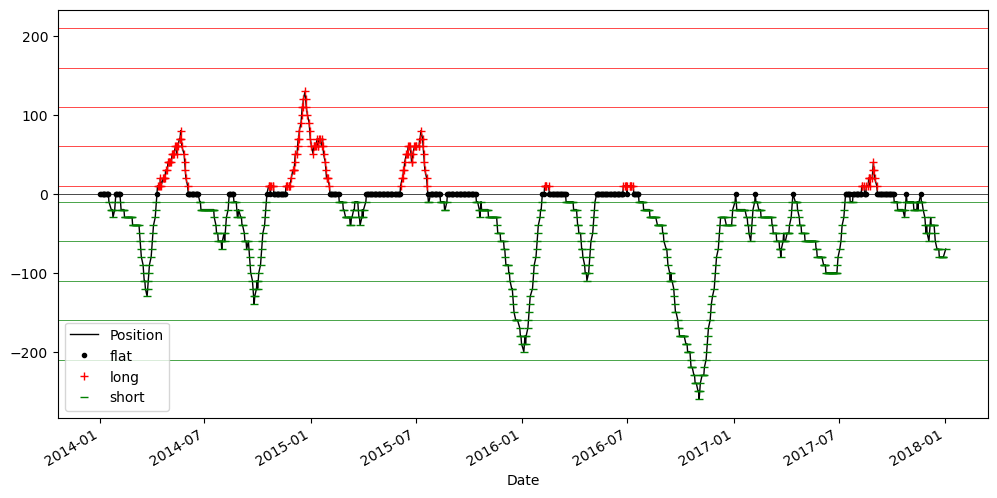

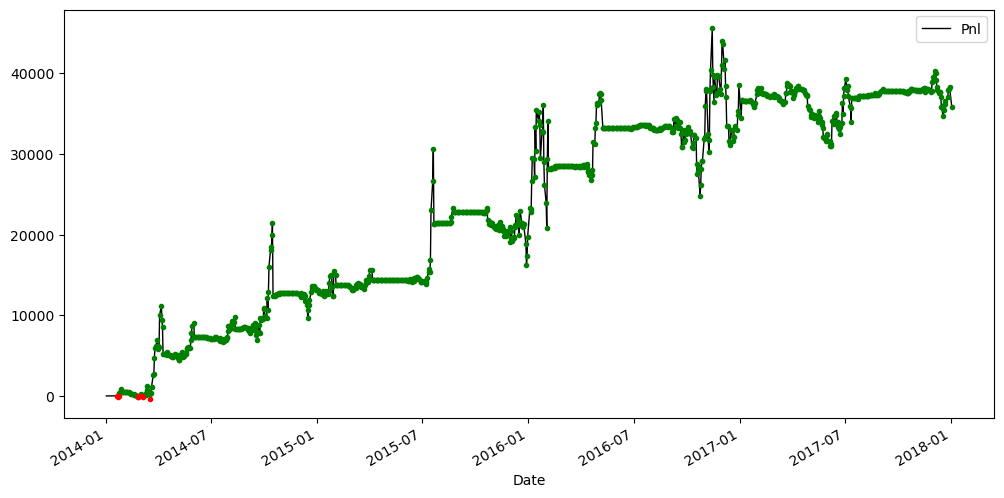

In [19]:
plt.figure(figsize=(12, 6))
df['Position'].plot(color='k', lw=1., legend=True)
plt.plot(df.loc[ df.Position == 0 ].index, df.Position[ df.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(df.loc[ df.Position > 0 ].index, df.Position[ df.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(df.loc[ df.Position < 0 ].index, df.Position[ df.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5 ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( -NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5 ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
df['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(df.loc[ df.Pnl > 0 ].index, df.Pnl[ df.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(df.loc[ df.Pnl < 0 ].index, df.Pnl[ df.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()

df['VolatilityAdjustedMeanReversionPnl'] = df['Pnl']
# data.to_csv("volatility_adjusted_mean_reversion.csv", sep=",")

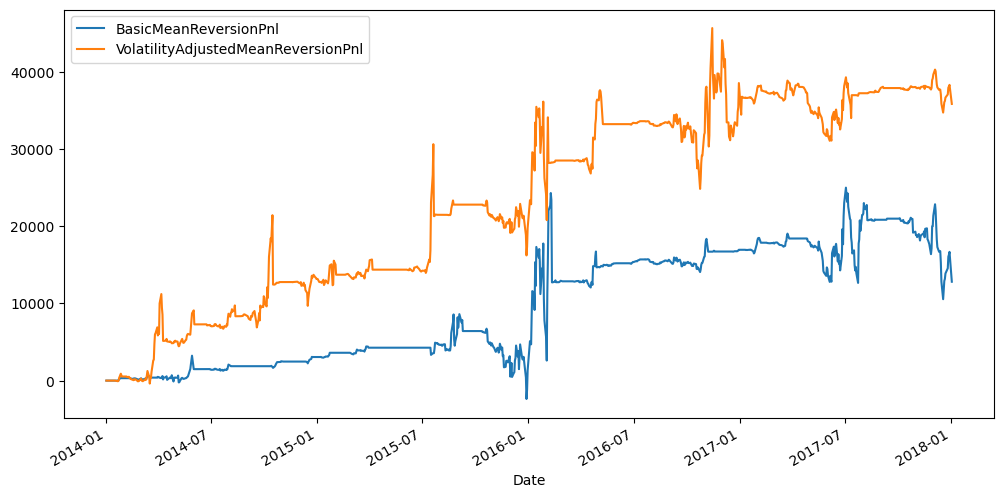

In [20]:
df[['BasicMeanReversionPnl', 'VolatilityAdjustedMeanReversionPnl']].plot(figsize=(12, 6))
plt.show()